# Package preparation

In [1]:
!pip install sctrend


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Download of the melanoma scRNA-seq dataset

In [ ]:
import urllib.request
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115978/suppl/GSE115978%5Fcounts.csv.gz"
urllib.request.urlretrieve(url, "GSE115978_counts.csv.gz")


('GSE115978_counts.csv.gz', <http.client.HTTPMessage at 0x11140f730>)

In [ ]:
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115978/suppl/GSE115978%5Fcell.annotations.csv.gz"
urllib.request.urlretrieve(url, "GSE115978_cell.annotations.csv.gz")


('GSE115978_cell.annotations.csv.gz', <http.client.HTTPMessage at 0x11140ffd0>)

# Import libraries

In [ ]:
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import os

# Preparation of single-cell and bulk RNA-seq

In [ ]:
from importlib.resources import files, as_file
base = files("sctrend") / "data"
ref_genes = (base / "SKCM_ref_5000genes_plus_BRAF.txt").read_text(encoding="utf-8").splitlines()
with as_file(base / "SKCM_umap_coordinates.csv") as p:
    umap_df = pd.read_csv(p, index_col=0)
with as_file(base / "SKCM_BRAF_checkpoint.pt") as p:
    ckpt_path = str(p)

In [ ]:
count_df = pd.read_csv("GSE115978_counts.csv.gz", index_col=0).T
annotation_df = pd.read_csv("GSE115978_cell.annotations.csv.gz", index_col=0)
sc_adata = sc.AnnData(X=csr_matrix(count_df.values), obs=annotation_df)
sc_adata.var_names = count_df.columns
sc_adata.obs = annotation_df
sc_adata.obs["cell.types"] = sc_adata.obs["cell.types"].replace("?", "Undefined")
sc_adata = sc_adata[umap_df.index].copy()
sc_adata.obsm["X_umap"] = umap_df[["UMAP1", "UMAP2"]].to_numpy()
sc_adata = sc_adata[:, ref_genes].copy()

# Run scTREND

### --- Reference: training / full pipeline (NOT executed in this tutorial) ---

In [33]:
# driver_genes = ["BRAF"]
# edges = [...]  # time bin edges used in training
#
# sc_adata, bulk_adata = workflow.scTREND_preprocess(sc_adata, bulk_adata,
#     per=0.01, n_top_genes=5000, highly_variable="bulk", driver_genes=driver_genes)
#
# driver_bulk_adata = bulk_adata[:, bulk_adata.var_names.isin(driver_genes)]
# driver_bulk_adata.layers["SNV"] = ...  # samples × driver_genes (0:wild-type 1:mutated)
#
# sc_adata, bulk_adata, model_params_dict, spatial_adata, exp = workflow.run_scTREND(
#     sc_adata, bulk_adata,
#     param_save_path="scTREND.pt",
#     epoch=10000,
#     batch_key="samples",
#     driver_genes=driver_genes,
#     driver_bulk_adata=driver_bulk_adata,
#     edges=edges
# )


### Loading a trained checkpoint

In [ ]:
import torch
import numpy as np
ckpt = torch.load(ckpt_path, map_location="cpu")
sc_adata.obsm["raw_beta_z"] = ckpt["raw_beta_z"]
sc_adata.obsm["raw_beta_z"] = ckpt["raw_gamma_BRAF_z"]

NameError: name 'ckpt_path' is not defined

# Visualization

/Users/shintaro/scSurvSNV_timedepend/.venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


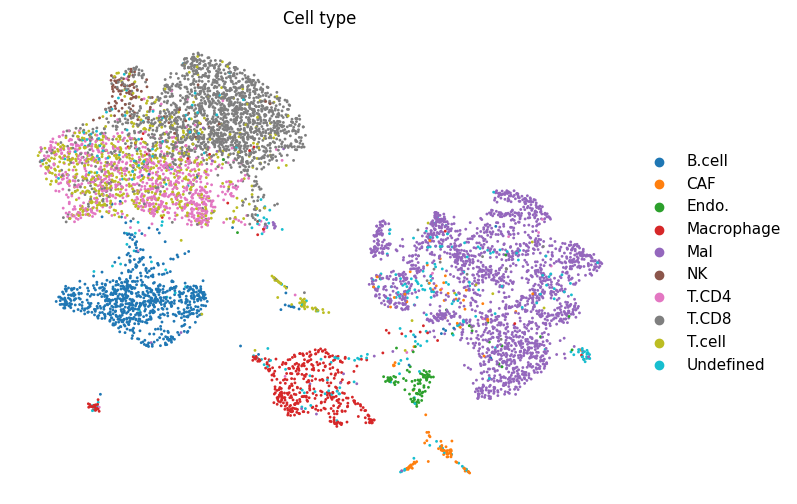

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(sc_adata, color="cell.types", ax=ax, show=False,
           colorbar_loc=None, frameon=False, legend_fontsize=11)
ax.set_title("Cell type")
plt.savefig("SKCM_umap_celltype.png", bbox_inches="tight", dpi=300)

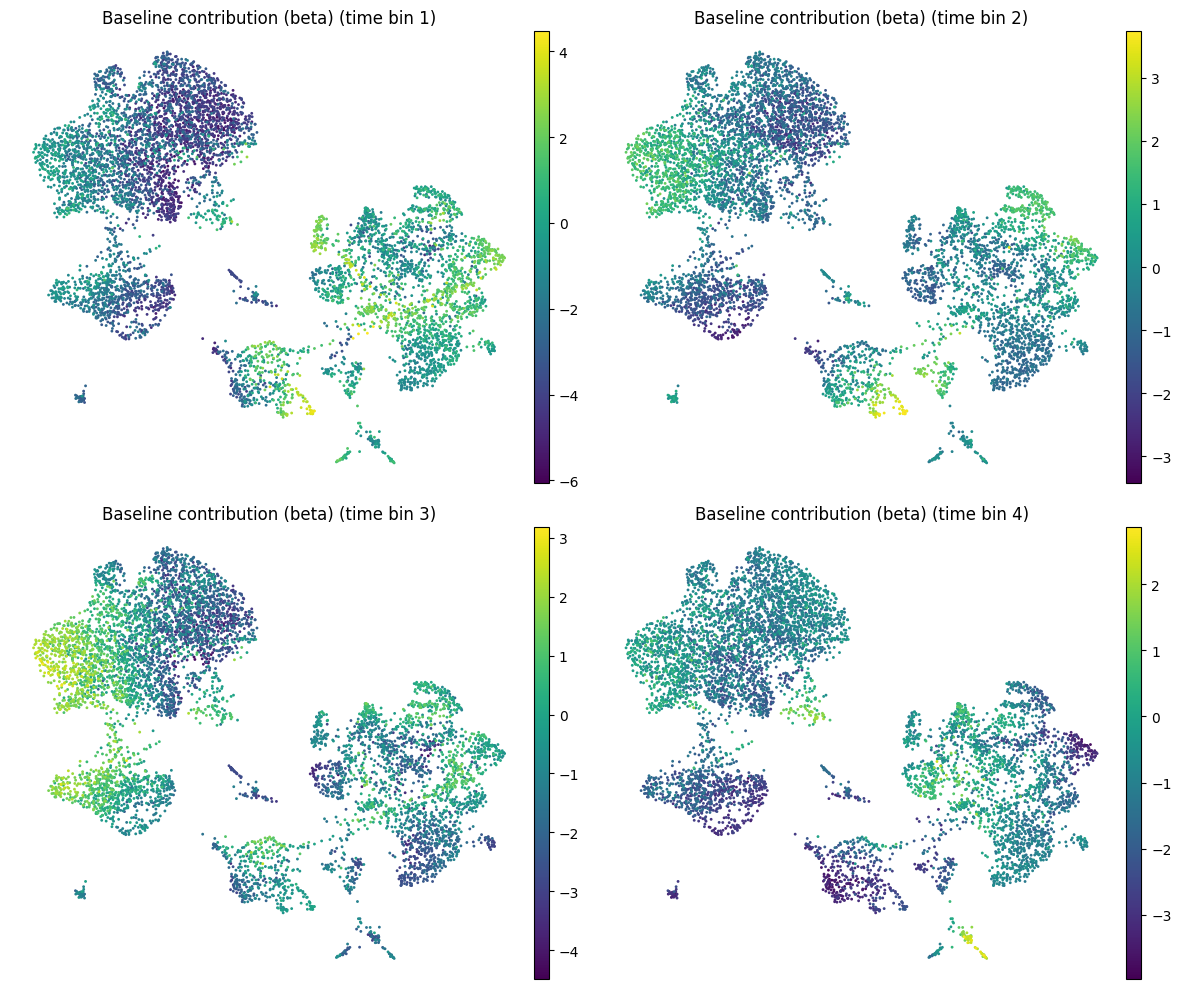

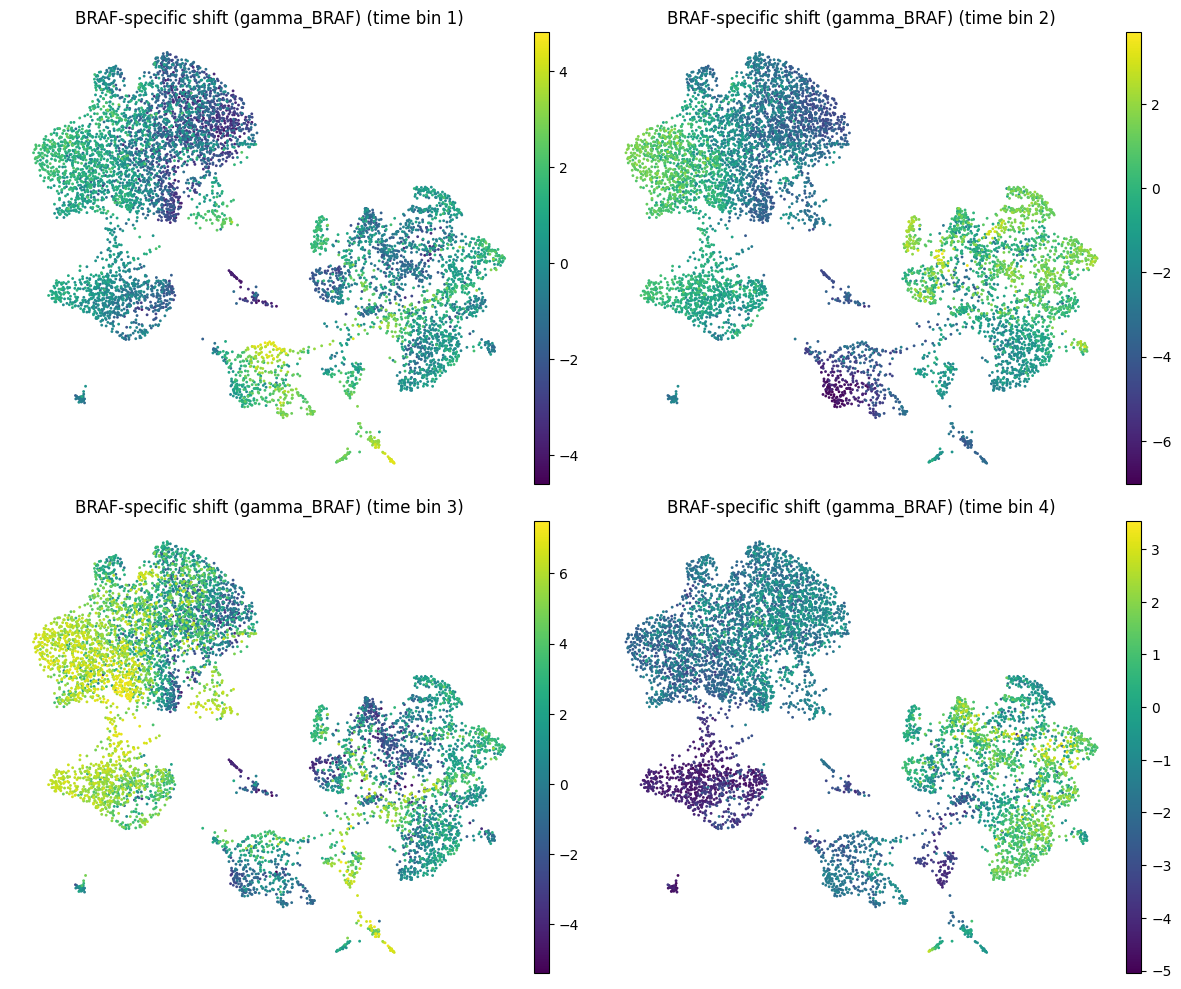

In [ ]:
def plot_umap_per_bin(adata, mat, *, prefix, title_prefix, out_png, ncols=2):
    mat = np.asarray(mat)
    K = mat.shape[1]
    nrows = int(np.ceil(K / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axes = np.array(axes).reshape(-1)

    for k in range(K):
        col = f"{prefix}_bin{k+1}"
        adata.obs[col] = mat[:, k]
        sc.pl.umap(
            adata, color=col, ax=axes[k], show=False,
            frameon=False, colorbar_loc="right",
            title=f"{title_prefix} (time bin {k+1})"
        )
        del adata.obs[col]

    for j in range(K, nrows*ncols):
        fig.delaxes(axes[j])

    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")

plot_umap_per_bin(
    sc_adata,
    sc_adata.obsm["raw_beta_z"],
    prefix="beta",
    title_prefix="Baseline contribution (beta)",
    out_png="umap_beta_per_bin.png",
)

plot_umap_per_bin(
    sc_adata,
    sc_adata.obsm["raw_gamma_BRAF_z"],
    prefix="gammaBRAF",
    title_prefix="BRAF-specific shift (gamma_BRAF)",
    out_png="umap_gamma_BRAF_per_bin.png",
)